In [23]:
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx 

In [24]:
dataset = MiniGCDataset(80,10,20)


In [25]:
#check how the dataset looks like 
#dataset[5:10]

Text(0.5, 1.0, 'Class :0')

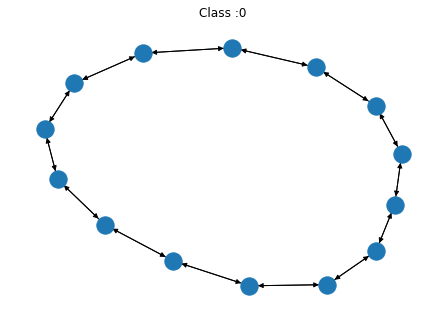

In [26]:
graph, label = dataset[0]
nx.draw(graph.to_networkx())
plt.title(f'Class :{label}')

In [27]:
import torch
import dgl
def collate(samples):
    #print(f"samples datatype{type(samples)}")
    graphs, labels = map(list, zip(*samples))
    #print(f"graphs and lables after map{graphs,labels},type{graphs}")
    batched_graph =dgl.batch(graphs)
    
    return batched_graph,torch.tensor(labels)


In [28]:
# test how mini batch forms: 
#test_sam = MiniGCDataset(5,10,20)

#collate(test_sam)

# summery : it adds all the nodes and edges


In [29]:
# how in_degrees works 
# g_test = test_sam[1][0]
#print(g_test.in_degrees(),g_test) 

In [30]:
from dgl.nn.pytorch import GraphConv

In [31]:
# aagregation and classification 

import torch.nn as nn
import torch.nn.functional as F 

class Classifier(nn.Module):
    def __init__(self,in_dim,hidden_dim,n_classes):
        super(Classifier,self).__init__()
        self.conv1 = GraphConv(in_dim,hidden_dim)
        self.conv2 = GraphConv(hidden_dim,hidden_dim)
        self.classify = nn.Linear(hidden_dim,n_classes)
        print(f"n_classes, {n_classes}")

    def forward(self,g): 
        h =g.in_degrees().view(-1,1).float()
        print(f"starting {h.size()}")
        h = F.relu(self.conv1(g,h))
        h = F.relu(self.conv2(g,h))
        g.ndata['h']=h
        print(f"hiddenlayer 2 h.size, {h.size()}")
        hg = dgl.mean_nodes(g,'h')
        print(f"hg size after mean {hg.size()}")
        hg = self.classify(hg)
        # print(f"hg size after classify {hg.size()}, {hg}")
        return hg
        
        

In [32]:
import torch.optim as optim
from torch.utils.data import DataLoader

trainset = MiniGCDataset(320,10,20)
testset = MiniGCDataset(80,10,20)

data_loader = DataLoader(trainset,batch_size=32, shuffle= True , collate_fn= collate)


model = Classifier(1,256,trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
model.train()
epochs = 1

losses = []

for epoch in range(epochs):
    
    for iter, (bg,label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print('Epoch {}, loss {:.4f}'.format(epoch, loss.item()))



n_classes, 8
starting torch.Size([444, 1])
hiddenlayer 2 h.size, torch.Size([444, 256])
hg size after mean torch.Size([32, 256])
starting torch.Size([428, 1])
hiddenlayer 2 h.size, torch.Size([428, 256])
hg size after mean torch.Size([32, 256])
starting torch.Size([437, 1])
hiddenlayer 2 h.size, torch.Size([437, 256])
hg size after mean torch.Size([32, 256])
starting torch.Size([455, 1])
hiddenlayer 2 h.size, torch.Size([455, 256])
hg size after mean torch.Size([32, 256])
starting torch.Size([443, 1])
hiddenlayer 2 h.size, torch.Size([443, 256])
hg size after mean torch.Size([32, 256])
starting torch.Size([442, 1])
hiddenlayer 2 h.size, torch.Size([442, 256])
hg size after mean torch.Size([32, 256])
starting torch.Size([441, 1])
hiddenlayer 2 h.size, torch.Size([441, 256])
hg size after mean torch.Size([32, 256])
starting torch.Size([440, 1])
hiddenlayer 2 h.size, torch.Size([440, 256])
hg size after mean torch.Size([32, 256])
starting torch.Size([412, 1])
hiddenlayer 2 h.size, torch.S

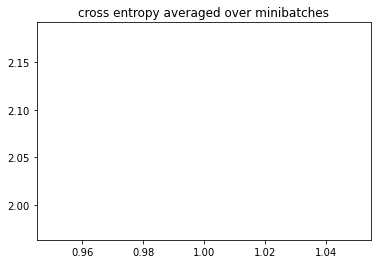

In [33]:
plt.title('cross entropy averaged over minibatches')
plt.plot(range(1,epochs+1),losses)


In [34]:
model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

starting torch.Size([1085, 1])
hiddenlayer 2 h.size, torch.Size([1085, 256])
hg size after mean torch.Size([80, 256])
Accuracy of sampled predictions on the test set: 20.0000%
Accuracy of argmax predictions on the test set: 12.500000%
